# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

# Convolutional Neural Network

## Ziel: 
### Training vom ersten Model mit [Cloud Computing Power](https://neptune.ml/)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
from torchvision import transforms, models

%matplotlib inline

import os
from os import walk
from os import listdir
from os.path import isfile, join

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# the follow code convert .jpg.jpg into .jpeg
# only need to run once
'''

root_dir = './input/images/images/'
ingore_files = ['.DS_Store', 'neptune.log']

sorted_food_dirs = [fd for fd in sorted(os.listdir(root_dir)) if not fd in ingore_files]

for i in range(len(sorted_food_dirs)):
    path = os.path.join(root_dir, sorted_food_dirs[i])
    for i, filename in enumerate(os.listdir(path)):
        src = f"{path}/{filename}"
        name = filename.split('.')[0] + ".jpeg"
        dst = f"{path}/{name}"
        os.rename(src, dst)
'''

'\n\nroot_dir = \'./input/images/images/\'\ningore_files = [\'.DS_Store\', \'neptune.log\']\n\nsorted_food_dirs = [fd for fd in sorted(os.listdir(root_dir)) if not fd in ingore_files]\n\nfor i in range(len(sorted_food_dirs)):\n    path = os.path.join(root_dir, sorted_food_dirs[i])\n    for i, filename in enumerate(os.listdir(path)):\n        src = f"{path}/{filename}"\n        name = filename.split(\'.\')[0] + ".jpeg"\n        dst = f"{path}/{name}"\n        os.rename(src, dst)\n'

In [4]:
# total number of images

import pathlib

data_dir = pathlib.Path("./input/images/images")

image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

8459


In [5]:
#
train_size = int(image_count*0.7)
val_size = image_count - train_size
batch_size = 32

print(train_size)

5921


In [6]:
transform = transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


dataset = torchvision.datasets.ImageFolder('./input/images/images/', transform=transform)
train, val= data.random_split(dataset, [train_size, val_size])

trainLoader = data.DataLoader(train, batch_size=batch_size, shuffle=True)
valLoader = data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [7]:
# labels (or folder names)
class_names = dataset.classes
print(class_names)

['bananen', 'cake', 'chili', 'cookies', 'curry', 'fisch', 'kaffee', 'muffins', 'nudel', 'pasta', 'pizza', 'salat', 'sandwich', 'sauce', 'smoothie', 'thai', 'toast', 'tofu', 'waffeln', 'wraps']


## Kategorien die sich ähneln oder keinen Mehwert ergeben (z.B "griechische", "weisse", "blech",...) werden gelöscht. Es bleiben noch 230 Kategorien

In [8]:
alex = models.alexnet(pretrained=True)
alex.to(device)

print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
alex.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# change the number of labels (default 1000 for vgg16)
alex.classifier[6].out_features = len(class_names)

#lock parameters
for para in alex.features.parameters():
    para.requires_grad = False

In [11]:
optimizer = optim.SGD(alex.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [12]:
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0
    val_running_correct = 0
    for i, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100 * val_running_correct/len(test_dataloader.dataset)
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')

    
    return val_loss, val_accuracy

In [13]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100 * train_running_correct/len(train_dataloader.dataset)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [14]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(alex, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(alex, valLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0973, Train Acc: 37.65
Validation Loss: 0.0655, Validation Acc: 41.73
Train Loss: 0.0519, Train Acc: 52.12
Validation Loss: 0.0549, Validation Acc: 51.38
Train Loss: 0.0444, Train Acc: 58.03
Validation Loss: 0.0544, Validation Acc: 51.93
Train Loss: 0.0367, Train Acc: 64.04
Validation Loss: 0.0542, Validation Acc: 52.92
Train Loss: 0.0306, Train Acc: 69.11
Validation Loss: 0.0552, Validation Acc: 52.40
Train Loss: 0.0251, Train Acc: 75.29
Validation Loss: 0.0559, Validation Acc: 51.85
Train Loss: 0.0210, Train Acc: 79.70
Validation Loss: 0.0569, Validation Acc: 51.81
Train Loss: 0.0176, Train Acc: 83.14
Validation Loss: 0.0586, Validation Acc: 51.69
Train Loss: 0.0155, Train Acc: 84.80
Validation Loss: 0.0593, Validation Acc: 50.91
Train Loss: 0.0122, Train Acc: 88.68
Validation Loss: 0.0603, Validation Acc: 53.35
34.43997912009557 minutes


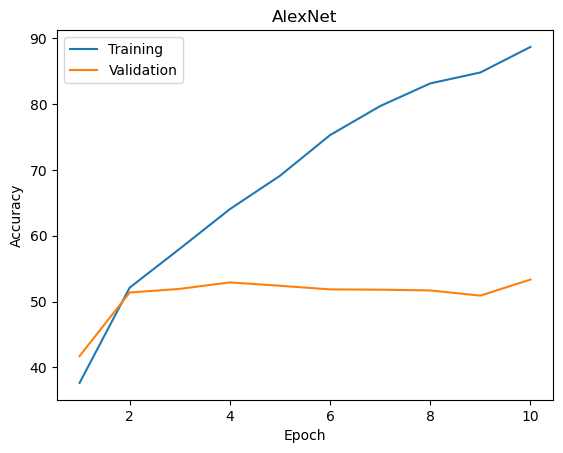

In [16]:
epoch = np.arange(1,11)
plt.title("AlexNet")
plt.plot(epoch, train_accuracy, label="Training")
plt.plot(epoch, val_accuracy, label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()